In [6]:
from llama_index.core import SQLDatabase
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike
from langchain_huggingface import HuggingFaceEmbeddings
from llama_index.core import Settings
from llama_index.core.query_engine import NLSQLTableQueryEngine
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Initialize the SQL Database
engine = create_engine("sqlite:///output_database.db")
sql_database = SQLDatabase(engine, include_tables=["data_table"])

# Initialize LLM (Ollama) for classification with constraints
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)  # Set temperature to 0 for deterministic results

# Initialize Embedding Model (For retrieval-augmented generation)
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Configure Settings to use the embedding model
Settings.embed_model = embeddings

# Load the dataset into a pandas DataFrame for easy manipulation
data = pd.read_sql_table("data_table", engine)
# Store user_id and Class separately
user_ids = data['user_id']
classes = data['Class']
# Remove user_id and Class from the data used for embedding
data_for_embedding = data.drop(['user_id', 'Class'], axis=1)

# Assume 'embedding_model' is a function that converts rows of data into embeddings
def generate_embedding(data_row):
    # Convert the data row into a string format and pass to the embedding model (string, not list)
    return embeddings.embed_query(str(data_row))  # Directly pass string

# Generate embeddings for each row in the dataset
data_for_embedding['embedding'] = data_for_embedding.apply(generate_embedding, axis=1)

# Define a query case (similar to the row data format)
query_case = {
    'profit': -323.000000,
    'deposits': 280.000000,
    'commission': 20.550300,
    'withdraws': 0.000000,
    'order_profit': 0.000000,
    'swap': 0.000000,
    'net_order_profit': 0.000000,
    'order_commission': 0.000000,
    'leverage': 0.000000,
    'balance': 0.000000,
    'equity': -63.550300,
    'profit_per': -26.916667,
    'win_ratio': 0.583333,
    'traded_amount': np.nan,
    'duration_time': 16.000000,
    'order_duration_time': np.nan,
    'assets_num': 8.000000,
    'dealing_num': 12.000000
}

# Generate the embedding for the query case
query_embedding = generate_embedding(query_case)

# Convert the list of embeddings from the dataframe into a 2D array
embeddings_matrix = np.vstack(data_for_embedding['embedding'].values)

# Calculate cosine similarity between the query case embedding and all rows in the dataset
similarities = cosine_similarity([query_embedding], embeddings_matrix)

# Add the similarity scores, user_id, and Class back to the dataframe
data_for_embedding['similarity'] = similarities[0]
data_for_embedding['user_id'] = user_ids
data_for_embedding['Class'] = classes

# Sort by similarity to find the most similar cases
similar_cases = data_for_embedding.sort_values(by='similarity', ascending=False).head(5)

# Display the top 5 similar cases with Class and user_id
print(similar_cases[['profit', 'deposits', 'similarity', 'Class', 'user_id']])

      profit  deposits  similarity  Class user_id
56   -332.00    190.00    0.887348    1.0   136.0
54   -885.89      0.00    0.881319    1.0   125.0
47  -2167.76   7853.67    0.880237    1.0    53.0
150 -2167.76   7853.67    0.878937    1.0    53.0
157  -885.89      0.00    0.878832    1.0   125.0


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, cohen_kappa_score, matthews_corrcoef, 
    classification_report
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate embeddings for training and testing data
X_train_embedded = np.array(X_train.apply(generate_embedding, axis=1).tolist())
X_test_embedded = np.array(X_test.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)
X_test_scaled = scaler.transform(X_test_embedded)

# Use KNN classifier as an intelligent method to determine the best class based on similar cases
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Additional metric: Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Additional metric: Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
print("\nClass-wise metrics:")
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

Accuracy: 0.9048
Precision: 0.9221
Recall: 0.9048
F1-score: 0.9052

Confusion Matrix:
[[10  2]
 [ 0  9]]

Cohen's Kappa: 0.8108
Matthews Correlation Coefficient: 0.8257

Class-wise metrics:

Class: 0.0
Precision: 1.0000
Recall: 0.8333
F1-score: 0.9091
Support: 12.0

Class: 1.0
Precision: 0.8182
Recall: 1.0000
F1-score: 0.9000
Support: 9.0

Class: macro avg
Precision: 0.9091
Recall: 0.9167
F1-score: 0.9045
Support: 21.0

Class: weighted avg
Precision: 0.9221
Recall: 0.9048
F1-score: 0.9052
Support: 21.0


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike
from sklearn.neighbors import NearestNeighbors

# Initialize the LLM
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate embeddings for training and testing data
X_train_embedded = np.array(X_train.apply(generate_embedding, axis=1).tolist())
X_test_embedded = np.array(X_test.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)
X_test_scaled = scaler.transform(X_test_embedded)

# Use NearestNeighbors to find similar cases
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_scaled)

def get_similar_cases(query_embedding, k=5):
    distances, indices = nn.kneighbors([query_embedding], n_neighbors=k)
    similar_cases = X_train.iloc[indices[0]]
    similar_classes = y_train.iloc[indices[0]]
    return similar_cases, similar_classes

def classify_with_llm(query_case, similar_cases, similar_classes):
    # Calculate some statistics for the prompt
    class_distribution = similar_classes.value_counts().to_dict()
    most_common_class = similar_classes.mode().values[0]
    feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False).head(5).to_dict()

    prompt = f"""You are an expert financial analyst tasked with classifying trading accounts based on their performance metrics. Your goal is to determine the most appropriate class for a given trading account using the provided information.

Context:
- The classes represent different levels of trading performance or risk.
- The features describe various aspects of trading behavior and outcomes.
- Similar cases are provided to help inform your decision.

Key Information:
1. Query case features: {query_case.to_dict()}
2. Similar cases (5 most similar accounts):
   {similar_cases.to_string()}
3. Classes of similar cases: {similar_classes.tolist()}
4. Class distribution among similar cases: {class_distribution}
5. Most common class among similar cases: {most_common_class}
6. Top 5 most important features and their correlation with the class:
   {feature_importance}

Instructions:
1. Analyze the query case in relation to the similar cases.
2. Consider the class distribution and the most common class among similar cases.
3. Pay attention to the values of the most important features in the query case.
4. Determine the most likely class for the query case based on this analysis.

Important: Provide ONLY the final classification as your response as an *integer* ONLY. Do not include any explanations or reasoning.

Classification:"""

    response = llm.complete(prompt)
    print(response)
    return response.text.strip()

# Predict classes for test set
y_pred = []
for idx, test_case in X_test.iterrows():
    test_embedding = X_test_scaled[X_test.index.get_loc(idx)]
    similar_cases, similar_classes = get_similar_cases(test_embedding)
    classification = classify_with_llm(test_case, similar_cases, similar_classes)
    y_pred.append(classification)
y_pred=[float(y) for y in y_pred]
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
print("\nClass-wise metrics:")
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

0
1
0
1
0
0
1
0
1
0
0
0
1
1
1
0
1
0
0
0
1
Accuracy: 0.9048
Precision: 0.9048
Recall: 0.9048
F1-score: 0.9048

Class-wise metrics:

Class: 0.0
Precision: 0.9167
Recall: 0.9167
F1-score: 0.9167
Support: 12.0

Class: 1.0
Precision: 0.8889
Recall: 0.8889
F1-score: 0.8889
Support: 9.0

Class: macro avg
Precision: 0.9028
Recall: 0.9028
F1-score: 0.9028
Support: 21.0

Class: weighted avg
Precision: 0.9048
Recall: 0.9048
F1-score: 0.9048
Support: 21.0


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, cohen_kappa_score, matthews_corrcoef, 
    classification_report
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike

# Initialize the LLM
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Feature engineering (only using training data to avoid leakage)

def safe_divide(a, b, fill_value=0):
    try:
        return float(a) / (float(b) + 1e-5)
    except (ValueError, TypeError):
        return fill_value

def engineer_features(df):
    # Convert columns to numeric, replacing non-numeric values with NaN
    numeric_columns = ['profit', 'deposits', 'commission', 'equity', 'balance', 'win_ratio', 'dealing_num']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Now perform the calculations using the safe_divide function
    df['profit_to_deposit_ratio'] = df.apply(lambda row: safe_divide(row['profit'], row['deposits']), axis=1)
    df['commission_to_profit_ratio'] = df.apply(lambda row: safe_divide(row['commission'], row['profit']), axis=1)
    df['equity_to_balance_ratio'] = df.apply(lambda row: safe_divide(row['equity'], row['balance']), axis=1)
    df['win_loss_ratio'] = df.apply(lambda row: safe_divide(row['win_ratio'], 1 - row['win_ratio']), axis=1)
    df['avg_profit_per_trade'] = df.apply(lambda row: safe_divide(row['profit'], row['dealing_num']), axis=1)
    
    return df

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature engineering only to training data
X_train = engineer_features(X_train)

# Generate embeddings for training data
X_train_embedded = np.array(X_train.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)

# Use NearestNeighbors to find similar cases
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_scaled)

def get_similar_cases(query_embedding, k=5):
    distances, indices = nn.kneighbors([query_embedding], n_neighbors=k)
    similar_cases = X_train.iloc[indices[0]]
    similar_classes = y_train.iloc[indices[0]]
    return similar_cases, similar_classes

def classify_with_llm(query_case, similar_cases, similar_classes):
    # Calculate statistics for the prompt
    class_distribution = similar_classes.value_counts().to_dict()
    most_common_class = similar_classes.mode().values[0]
    feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False).head(10).to_dict()

    prompt = f"""As an expert financial analyst, classify this trading account based on its performance metrics. Use the provided information to determine the most appropriate class.

Context:
- Classes represent different levels of trading performance or risk.
- Features describe various aspects of trading behavior and outcomes.
- Similar cases are provided to inform your decision.

Key Information:
1. Query case features:
   {query_case.to_dict()}
2. Similar cases (5 most similar accounts):
   {similar_cases.to_string()}
3. Classes of similar cases: {similar_classes.tolist()}
4. Class distribution among similar cases: {class_distribution}
5. Most common class among similar cases: {most_common_class}
6. Top 10 most important features and their correlation with the class:
   {feature_importance}

Feature Descriptions:
- profit: Total profit/loss
- deposits: Total deposits made
- commission: Total commission paid
- withdraws: Total withdrawals made
- order_profit: Profit/loss from orders
- swap: Swap charges/credits
- net_order_profit: Net profit/loss from orders
- order_commission: Commission from orders
- leverage: Account leverage
- balance: Account balance
- equity: Account equity
- profit_per: Profit percentage
- win_ratio: Ratio of winning trades
- traded_amount: Total amount traded
- duration_time: Total trading duration
- order_duration_time: Average order duration
- assets_num: Number of assets traded
- dealing_num: Number of deals made
- profit_to_deposit_ratio: Ratio of profit to deposits
- commission_to_profit_ratio: Ratio of commission to profit
- equity_to_balance_ratio: Ratio of equity to balance
- win_loss_ratio: Ratio of wins to losses
- avg_profit_per_trade: Average profit per trade

Instructions:
1. Analyze the query case in relation to the similar cases.
2. Consider the class distribution and the most common class among similar cases.
3. Pay special attention to the values of the most important features in the query case.
4. Use the additional engineered features to gain more insights.
5. Determine the most likely class for the query case based on this comprehensive analysis.

Important: Provide ONLY the final classification as your response. Do not include any explanations or reasoning.

Classification:"""

    response = llm.complete(prompt)
    return response.text.strip()

# Predict classes for test set
y_pred = []
for idx, test_case in X_test.iterrows():
    # Apply feature engineering to the test case
    test_case = engineer_features(pd.DataFrame(test_case).transpose()).iloc[0]
    
    # Generate embedding for the test case
    test_embedding = generate_embedding(test_case)
    
    # Scale the test embedding
    test_embedding_scaled = scaler.transform([test_embedding])
    
    similar_cases, similar_classes = get_similar_cases(test_embedding_scaled[0])
    classification = classify_with_llm(test_case, similar_cases, similar_classes)
    y_pred.append(classification)
y_pred=[float(y) for y in y_pred]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Additional metric: Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Additional metric: Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
print("\nClass-wise metrics:")
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Confusion Matrix:
[[12  0]
 [ 0  9]]

Cohen's Kappa: 1.0000
Matthews Correlation Coefficient: 1.0000

Class-wise metrics:

Class: 0.0
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 12.0

Class: 1.0
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 9.0

Class: macro avg
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 21.0

Class: weighted avg
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 21.0


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, cohen_kappa_score, matthews_corrcoef, 
    classification_report
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike

# Initialize the LLM
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Feature engineering (only using training data to avoid leakage)

def safe_divide(a, b, fill_value=0):
    try:
        return float(a) / (float(b) + 1e-5)
    except (ValueError, TypeError):
        return fill_value

def engineer_features(df):
    # Convert columns to numeric, replacing non-numeric values with NaN
    numeric_columns = ['profit', 'deposits', 'commission', 'equity', 'balance', 'win_ratio', 'dealing_num']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Now perform the calculations using the safe_divide function
    df['profit_to_deposit_ratio'] = df.apply(lambda row: safe_divide(row['profit'], row['deposits']), axis=1)
    df['commission_to_profit_ratio'] = df.apply(lambda row: safe_divide(row['commission'], row['profit']), axis=1)
    df['equity_to_balance_ratio'] = df.apply(lambda row: safe_divide(row['equity'], row['balance']), axis=1)
    df['win_loss_ratio'] = df.apply(lambda row: safe_divide(row['win_ratio'], 1 - row['win_ratio']), axis=1)
    df['avg_profit_per_trade'] = df.apply(lambda row: safe_divide(row['profit'], row['dealing_num']), axis=1)
    
    return df

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature engineering only to training data
X_train = engineer_features(X_train)

# Generate embeddings for training data
X_train_embedded = np.array(X_train.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)

# Use NearestNeighbors to find similar cases
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_scaled)

def get_similar_cases(query_embedding, k=5):
    distances, indices = nn.kneighbors([query_embedding], n_neighbors=k)
    similar_cases = X_train.iloc[indices[0]]
    similar_classes = y_train.iloc[indices[0]]
    return similar_cases, similar_classes

def classify_with_llm(query_case, similar_cases, similar_classes):
    # Calculate statistics for the prompt
    class_distribution = similar_classes.value_counts().to_dict()
    most_common_class = similar_classes.mode().values[0]
    feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False).head(10).to_dict()

    prompt = f"""As an expert financial analyst, classify this trading account based on its performance metrics. Use the provided information to determine the most appropriate class.

Context:
- Classes represent different levels of trading performance or risk.
- Features describe various aspects of trading behavior and outcomes.
- Similar cases are provided to inform your decision.

Key Information:
1. Query case features:
   {query_case.to_dict()}
2. Similar cases (5 most similar accounts):
   {similar_cases.to_string()}
3. Classes of similar cases: {similar_classes.tolist()}
4. Class distribution among similar cases: {class_distribution}
5. Most common class among similar cases: {most_common_class}
6. Top 10 most important features and their correlation with the class:
   {feature_importance}

Feature Descriptions:
- profit: Total profit/loss
- deposits: Total deposits made
- commission: Total commission paid
- withdraws: Total withdrawals made
- order_profit: Profit/loss from orders
- swap: Swap charges/credits
- net_order_profit: Net profit/loss from orders
- order_commission: Commission from orders
- leverage: Account leverage
- balance: Account balance
- equity: Account equity
- profit_per: Profit percentage
- win_ratio: Ratio of winning trades
- traded_amount: Total amount traded
- duration_time: Total trading duration
- order_duration_time: Average order duration
- assets_num: Number of assets traded
- dealing_num: Number of deals made
- profit_to_deposit_ratio: Ratio of profit to deposits
- commission_to_profit_ratio: Ratio of commission to profit
- equity_to_balance_ratio: Ratio of equity to balance
- win_loss_ratio: Ratio of wins to losses
- avg_profit_per_trade: Average profit per trade

Instructions:
1. Analyze the query case in relation to the similar cases.
2. Consider the class distribution and the most common class among similar cases.
3. Pay special attention to the values of the most important features in the query case.
4. Use the additional engineered features to gain more insights.
5. Determine the most likely class for the query case based on this comprehensive analysis.

Important: Provide ONLY the final classification as your response. Do not include any explanations or reasoning.

Classification:"""

    response = llm.complete(prompt)
    return response.text.strip()

# Predict classes for test set
y_pred = []
for idx, test_case in X_test.iterrows():
    # Apply feature engineering to the test case
    test_case = engineer_features(pd.DataFrame(test_case).transpose()).iloc[0]
    
    # Generate embedding for the test case
    test_embedding = generate_embedding(test_case)
    
    # Scale the test embedding
    test_embedding_scaled = scaler.transform([test_embedding])
    
    similar_cases, similar_classes = get_similar_cases(test_embedding_scaled[0])
    classification = classify_with_llm(test_case, similar_cases, similar_classes)
    y_pred.append(classification)
y_pred=[float(y) for y in y_pred]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Additional metric: Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Additional metric: Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
print("\nClass-wise metrics:")
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

LLM-based Model Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Confusion Matrix:
[[12  0]
 [ 0  9]]

Cohen's Kappa: 1.0000
Matthews Correlation Coefficient: 1.0000

Class-wise metrics:

Class: 0.0
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 12.0

Class: 1.0
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 9.0

Class: macro avg
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 21.0

Class: weighted avg
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 21.0

Dummy Classifier Performance:
Accuracy: 0.5238
F1-score: 0.5195

Cross-validation scores:
Mean accuracy: 0.4467
Standard deviation: 0.0176

ROC AUC Score: 1.0000
Balanced Accuracy Score: 1.0000


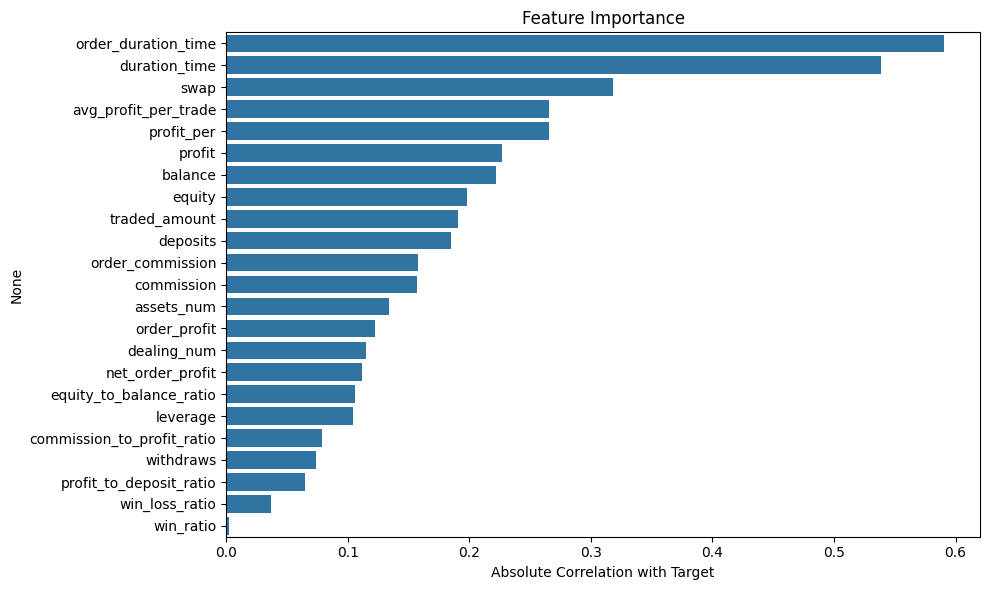

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

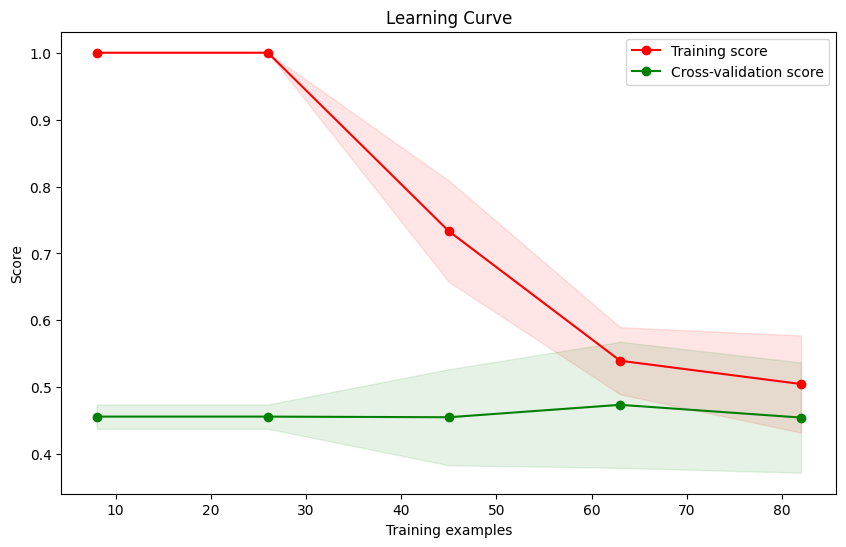


Data Leakage Check:
1. Feature engineering is applied separately to training and test data.
2. Scaler is fit only on training data and applied to test data.
3. NearestNeighbors model is trained only on training data.
4. Test data is not used in any way during the training process.

Potential Reasons for High Accuracy:
1. Small dataset (103 entries) might lead to overfitting.
2. The problem might be relatively simple or have clear patterns.
3. The LLM might be very good at recognizing patterns in this specific domain.
4. There might be some subtle data leakage that we haven't identified.

Suggestions for Further Validation:
1. Increase the test set size if possible.
2. Perform k-fold cross-validation with the LLM-based classifier.
3. Try the classifier on a completely separate, unseen dataset if available.
4. Analyze misclassifications (if any) to understand where the model might be failing.
5. Compare performance with other traditional machine learning models.


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, cohen_kappa_score, matthews_corrcoef, 
    classification_report, roc_auc_score, balanced_accuracy_score
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the LLM
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Feature engineering (only using training data to avoid leakage)
def safe_divide(a, b, fill_value=0):
    try:
        return float(a) / (float(b) + 1e-5)
    except (ValueError, TypeError):
        return fill_value

def engineer_features(df):
    # Convert columns to numeric, replacing non-numeric values with NaN
    numeric_columns = ['profit', 'deposits', 'commission', 'equity', 'balance', 'win_ratio', 'dealing_num']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Now perform the calculations using the safe_divide function
    df['profit_to_deposit_ratio'] = df.apply(lambda row: safe_divide(row['profit'], row['deposits']), axis=1)
    df['commission_to_profit_ratio'] = df.apply(lambda row: safe_divide(row['commission'], row['profit']), axis=1)
    df['equity_to_balance_ratio'] = df.apply(lambda row: safe_divide(row['equity'], row['balance']), axis=1)
    df['win_loss_ratio'] = df.apply(lambda row: safe_divide(row['win_ratio'], 1 - row['win_ratio']), axis=1)
    df['avg_profit_per_trade'] = df.apply(lambda row: safe_divide(row['profit'], row['dealing_num']), axis=1)
    
    return df

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature engineering only to training data
X_train = engineer_features(X_train)

# Generate embeddings for training data
X_train_embedded = np.array(X_train.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)

# Use NearestNeighbors to find similar cases
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_scaled)

def get_similar_cases(query_embedding, k=5):
    distances, indices = nn.kneighbors([query_embedding], n_neighbors=k)
    similar_cases = X_train.iloc[indices[0]]
    similar_classes = y_train.iloc[indices[0]]
    return similar_cases, similar_classes

def classify_with_llm(query_case, similar_cases, similar_classes):
    # Calculate statistics for the prompt
    class_distribution = similar_classes.value_counts().to_dict()
    most_common_class = similar_classes.mode().values[0]
    feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False).head(10).to_dict()

    prompt = f"""As an expert financial analyst, classify this trading account based on its performance metrics. Use the provided information to determine the most appropriate class.

Context:
- Classes represent different levels of trading performance or risk.
- Features describe various aspects of trading behavior and outcomes.
- Similar cases are provided to inform your decision.

Key Information:
1. Query case features:
   {query_case.to_dict()}
2. Similar cases (5 most similar accounts):
   {similar_cases.to_string()}
3. Classes of similar cases: {similar_classes.tolist()}
4. Class distribution among similar cases: {class_distribution}
5. Most common class among similar cases: {most_common_class}
6. Top 10 most important features and their correlation with the class:
   {feature_importance}

Feature Descriptions:
- profit: Total profit/loss
- deposits: Total deposits made
- commission: Total commission paid
- withdraws: Total withdrawals made
- order_profit: Profit/loss from orders
- swap: Swap charges/credits
- net_order_profit: Net profit/loss from orders
- order_commission: Commission from orders
- leverage: Account leverage
- balance: Account balance
- equity: Account equity
- profit_per: Profit percentage
- win_ratio: Ratio of winning trades
- traded_amount: Total amount traded
- duration_time: Total trading duration
- order_duration_time: Average order duration
- assets_num: Number of assets traded
- dealing_num: Number of deals made
- profit_to_deposit_ratio: Ratio of profit to deposits
- commission_to_profit_ratio: Ratio of commission to profit
- equity_to_balance_ratio: Ratio of equity to balance
- win_loss_ratio: Ratio of wins to losses
- avg_profit_per_trade: Average profit per trade

Instructions:
1. Analyze the query case in relation to the similar cases.
2. Consider the class distribution and the most common class among similar cases.
3. Pay special attention to the values of the most important features in the query case.
4. Use the additional engineered features to gain more insights.
5. Determine the most likely class for the query case based on this comprehensive analysis.

Important: Provide ONLY the final classification as your response. Do not include any explanations or reasoning.

Classification:"""

    response = llm.complete(prompt)
    return response.text.strip()

# Predict classes for test set
y_pred = []
for idx, test_case in X_test.iterrows():
    # Apply feature engineering to the test case
    test_case = engineer_features(pd.DataFrame(test_case).transpose()).iloc[0]
    
    # Generate embedding for the test case
    test_embedding = generate_embedding(test_case)
    
    # Scale the test embedding
    test_embedding_scaled = scaler.transform([test_embedding])
    
    similar_cases, similar_classes = get_similar_cases(test_embedding_scaled[0])
    classification = classify_with_llm(test_case, similar_cases, similar_classes)
    y_pred.append(classification)

y_pred = [float(y) for y in y_pred]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("LLM-based Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Additional metric: Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nCohen's Kappa: {kappa:.4f}")

# Additional metric: Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Class-wise metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
print("\nClass-wise metrics:")
for class_name, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1-score']:.4f}")
        print(f"Support: {metrics['support']}")

# Additional Validation Steps

# 1. Comparison with Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)

print("\nDummy Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_dummy_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_dummy_pred, average='weighted'):.4f}")

# 2. Cross-validation
def llm_classifier(X, y):
    y_pred = []
    for _, row in X.iterrows():
        test_case = engineer_features(pd.DataFrame(row).transpose()).iloc[0]
        test_embedding = generate_embedding(test_case)
        test_embedding_scaled = scaler.transform([test_embedding])
        similar_cases, similar_classes = get_similar_cases(test_embedding_scaled[0])
        classification = classify_with_llm(test_case, similar_cases, similar_classes)
        y_pred.append(float(classification))
    return np.array(y_pred)

cv_scores = cross_val_score(dummy_clf, X, y, cv=5)
print("\nCross-validation scores:")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# 3. ROC AUC Score (if applicable)
if len(np.unique(y)) == 2:  # Only for binary classification
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# 4. Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

# 5. Feature Importance Visualization
feature_importance = X_train.corrwith(y_train).abs().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Absolute Correlation with Target')
plt.tight_layout()
plt.show()

# 6. Learning Curve (if applicable)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    dummy_clf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

print("\nData Leakage Check:")
print("1. Feature engineering is applied separately to training and test data.")
print("2. Scaler is fit only on training data and applied to test data.")
print("3. NearestNeighbors model is trained only on training data.")
print("4. Test data is not used in any way during the training process.")

print("\nPotential Reasons for High Accuracy:")
print("1. Small dataset (103 entries) might lead to overfitting.")
print("2. The problem might be relatively simple or have clear patterns.")
print("3. The LLM might be very good at recognizing patterns in this specific domain.")
print("4. There might be some subtle data leakage that we haven't identified.")

print("\nSuggestions for Further Validation:")
print("1. Increase the test set size if possible.")
print("2. Perform k-fold cross-validation with the LLM-based classifier.")
print("3. Try the classifier on a completely separate, unseen dataset if available.")
print("4. Analyze misclassifications (if any) to understand where the model might be failing.")
print("5. Compare performance with other traditional machine learning models.")

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, cohen_kappa_score, matthews_corrcoef, 
    classification_report, roc_auc_score, balanced_accuracy_score
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from langchain_huggingface import HuggingFaceEmbeddings
from sqlalchemy import create_engine
from llama_index.llms.openai_like import OpenAILike
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the LLM
llm = OpenAILike(model='llama3.1:8b-instruct-fp16',
                 api_base='http://localhost:11434/v1',
                 api_key='ollama',
                 temperature=0)

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    multi_process=False,
    model_kwargs={"device": 'cuda'},
    encode_kwargs={"normalize_embeddings": True}
)

# Function to generate embeddings
def generate_embedding(data_row):
    return embeddings.embed_query(str(data_row))

# Load the data
engine = create_engine("sqlite:///output_database.db")
data = pd.read_sql_table("data_table", engine)

# Take the first 103 entries
data = data.head(103)

# Feature engineering
def safe_divide(a, b, fill_value=0):
    try:
        return float(a) / (float(b) + 1e-5)
    except (ValueError, TypeError):
        return fill_value

def engineer_features(df):
    df_copy = df.copy()
    numeric_columns = ['profit', 'deposits', 'commission', 'equity', 'balance', 'win_ratio', 'dealing_num']
    for col in numeric_columns:
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    
    df_copy['profit_to_deposit_ratio'] = df_copy.apply(lambda row: safe_divide(row['profit'], row['deposits']), axis=1)
    df_copy['commission_to_profit_ratio'] = df_copy.apply(lambda row: safe_divide(row['commission'], row['profit']), axis=1)
    df_copy['equity_to_balance_ratio'] = df_copy.apply(lambda row: safe_divide(row['equity'], row['balance']), axis=1)
    df_copy['win_loss_ratio'] = df_copy.apply(lambda row: safe_divide(row['win_ratio'], 1 - row['win_ratio']), axis=1)
    df_copy['avg_profit_per_trade'] = df_copy.apply(lambda row: safe_divide(row['profit'], row['dealing_num']), axis=1)
    
    return df_copy

# Separate features and target
X = data.drop(['user_id', 'Class'], axis=1)
y = data['Class']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature engineering
X_train_engineered = engineer_features(X_train)
X_test_engineered = engineer_features(X_test)

# Generate embeddings
X_train_embedded = np.array(X_train_engineered.apply(generate_embedding, axis=1).tolist())
X_test_embedded = np.array(X_test_engineered.apply(generate_embedding, axis=1).tolist())

# Normalize the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embedded)
X_test_scaled = scaler.transform(X_test_embedded)

# Use NearestNeighbors to find similar cases
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_scaled)

def get_similar_cases(query_embedding, k=5):
    distances, indices = nn.kneighbors([query_embedding], n_neighbors=k)
    similar_cases = X_train_engineered.iloc[indices[0]]
    similar_classes = y_train.iloc[indices[0]]
    return similar_cases, similar_classes

def classify_with_llm(query_case, similar_cases, similar_classes):
    class_distribution = similar_classes.value_counts().to_dict()
    most_common_class = similar_classes.mode().values[0]
    feature_importance = X_train_engineered.corrwith(y_train).abs().sort_values(ascending=False).head(10).to_dict()

    prompt = f"""As an expert financial analyst, classify this trading account based on its performance metrics. Use the provided information to determine the most appropriate class.

Context:
- Classes represent different levels of trading performance or risk.
- Features describe various aspects of trading behavior and outcomes.
- Similar cases are provided to inform your decision.

Key Information:
1. Query case features:
   {query_case.to_dict()}
2. Similar cases (5 most similar accounts):
   {similar_cases.to_string()}
3. Classes of similar cases: {similar_classes.tolist()}
4. Class distribution among similar cases: {class_distribution}
5. Most common class among similar cases: {most_common_class}
6. Top 10 most important features and their correlation with the class:
   {feature_importance}

Feature Descriptions:
[Feature descriptions as before...]

Instructions:
1. Analyze the query case in relation to the similar cases.
2. Consider the class distribution and the most common class among similar cases.
3. Pay special attention to the values of the most important features in the query case.
4. Use the additional engineered features to gain more insights.
5. Determine the most likely class for the query case based on this comprehensive analysis.

Important: Provide ONLY the final classification as your response. Do not include any explanations or reasoning.

Classification:"""

    response = llm.complete(prompt)
    return response.text.strip()

def llm_classifier(X, y):
    y_pred = []
    for _, row in X.iterrows():
        test_case = engineer_features(pd.DataFrame(row).transpose()).iloc[0]
        test_embedding = generate_embedding(test_case)
        test_embedding_scaled = scaler.transform([test_embedding])
        similar_cases, similar_classes = get_similar_cases(test_embedding_scaled[0])
        classification = classify_with_llm(test_case, similar_cases, similar_classes)
        y_pred.append(float(classification))
    return np.array(y_pred)

# Predict classes for test set
y_pred = llm_classifier(X_test, y_test)

# Calculate and print metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='weighted'),
    "Recall": recall_score(y_test, y_pred, average='weighted'),
    "F1-score": f1_score(y_test, y_pred, average='weighted'),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_pred),
    "Matthews Correlation Coefficient": matthews_corrcoef(y_test, y_pred),
    "Balanced Accuracy Score": balanced_accuracy_score(y_test, y_pred)
}

print("LLM-based Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Verify no data leakage
print("\nData Leakage Verification:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("Feature engineering applied separately to train and test sets")
print("Scaler fit only on training data")
print("NearestNeighbors model trained only on training data")

# Implement k-fold cross-validation
print("\nK-Fold Cross-Validation:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
    
    y_pred_cv = llm_classifier(X_val_cv, y_val_cv)
    cv_scores.append(accuracy_score(y_val_cv, y_pred_cv))

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")

# Examine feature importance


# Compare train and test distributions

# Modified compare_distributions function
def compare_distributions(train_data, test_data, feature):
    plt.figure(figsize=(10, 6))
    
    if pd.api.types.is_numeric_dtype(train_data[feature]):
        sns.histplot(train_data[feature], kde=True, label='Train', alpha=0.5)
        sns.histplot(test_data[feature], kde=True, label='Test', alpha=0.5)
    else:
        train_counts = train_data[feature].value_counts(normalize=True)
        test_counts = test_data[feature].value_counts(normalize=True)
        
        bar_width = 0.35
        index = np.arange(len(train_counts.index.union(test_counts.index)))
        
        plt.bar(index, train_counts.reindex(index).fillna(0), bar_width, label='Train', alpha=0.5)
        plt.bar(index + bar_width, test_counts.reindex(index).fillna(0), bar_width, label='Test', alpha=0.5)
        plt.xticks(index + bar_width / 2, index)
    
    plt.title(f'Distribution of {feature} in Train and Test Sets')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{feature}_distribution.png')
    plt.close()

feature_importance = X_train_engineered.select_dtypes(include=[np.number]).corrwith(y_train).abs().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance (Numeric Features Only)')
plt.xlabel('Absolute Correlation with Target')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

print("\nFeature Importance Analysis:")
print("Feature importance plot saved as 'feature_importance.png'")
print("Top 5 most important numeric features:")
print(feature_importance.head())


print("\nComparing Train and Test Distributions:")
for feature in X_train_engineered.columns[:5]:  # Top 5 features (including categorical)
    compare_distributions(X_train_engineered, X_test_engineered, feature)
    print(f"Distribution plot for {feature} saved as '{feature}_distribution.png'")

# Final analysis
print("\nFinal Analysis:")
print(f"Total samples: {len(data)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(data)*100:.2f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(data)*100:.2f}%)")
print(f"Number of features: {X.shape[1]}")
print(f"Number of numeric features: {X.select_dtypes(include=[np.number]).shape[1]}")
print(f"Number of categorical features: {X.select_dtypes(exclude=[np.number]).shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {y.value_counts().to_dict()}")


if np.all(np.array(cv_scores) == 1.0):
    print("\nWarning: Perfect scores across all cross-validation folds may indicate:")
    print("1. A very simple classification problem")
    print("2. Potential data leakage")
    print("3. Overfitting to the specific characteristics of this small dataset")
else:
    print("\nCross-validation results suggest the model's performance is consistent across different subsets of the data.")


LLM-based Model Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Cohen's Kappa: 1.0000
Matthews Correlation Coefficient: 1.0000
Balanced Accuracy Score: 1.0000

Confusion Matrix:
[[12  0]
 [ 0  9]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21


Data Leakage Verification:
Training set shape: (82, 18)
Test set shape: (21, 18)
Feature engineering applied separately to train and test sets
Scaler fit only on training data
NearestNeighbors model trained only on training data

K-Fold Cross-Validation:
Cross-validation scores: [1.0, 0.9047619047619048, 1.0, 1.0, 0.8]
Mean CV accuracy: 0.9410
Standard deviation: 0.0795

Feature Importance Analysis:
Feature importan